# Load_Important_Libraries 

In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation,BatchNormalization

# Load_Data

In [2]:
# Define dataset paths
data_covid = r"D:\AMIT Course\Data Set\Image Classification - Covid-19 X-Ray\archive\COVID19"
data_normal = r"D:\AMIT Course\Data Set\Image Classification - Covid-19 X-Ray\archive\Normal"

# Initialize lists
filepaths = []
labels = []

# Function to read images from a directory
def load_images_from_folder(data_path, label_name):
    for file in os.listdir(data_path):
        filepaths.append(os.path.join(data_path, file))
        labels.append(label_name)

# Load COVID images
load_images_from_folder(data_covid, "COVID19")

# Load Normal images
load_images_from_folder(data_normal, "Normal")

# Create a combined DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split_Data

In [3]:
# First, split into train+valid and test (80-20 split)
train_valid_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Then, split train+valid into train and validation (75-25 split)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, stratify=train_valid_df['labels'], random_state=42)

# Final splits:
# Train: 60%, Validation: 20%, Test: 20%

# Dataset Sizes

In [4]:
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

Train size: 36
Validation size: 12
Test size: 12


# Data_Augmentation 

In [5]:
# Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    #validation_split=0.2
)

def preprocess_image(image):
    return image.astype('float32') / 255. 
    
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

Found 36 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.


# Add_Transfer_Learning

In [6]:
base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling="max",
    classes=1000,
    classifier_activation="softmax",
    name="inception_resnet_v2",)
base_model.trainable = False

In [7]:
# base_model = MobileNetV2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224, 224, 3),
#     pooling="max",
#     classes=1000,
#     classifier_activation="softmax",
#     name="inception_resnet_v2",)
# base_model.trainable = False

In [8]:
# base_model = VGG16(
#      include_top=False,
#      weights="imagenet",
#      input_tensor=None,
#      input_shape=(224, 224, 3),
#      pooling=max,
#      classes=1000,
#      classifier_activation="softmax",
#      name="inception_resnet_v2",)

# base_model.trainable = False

# CNN

In [9]:
model = Sequential([
    base_model, 
    # Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
   # Dropout(0.2),
    Dense(2, activation='softmax')  
])

model.compile(optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,298,306 (210.95 MB)

 Trainable params: 961,570 (3.67 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Early stopping if validation loss doesn't improve for 3 epochs

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Save the best model during training

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

# Reduce learning rate if validation loss plateaus

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3           # Number of epochs to wait before reducing LR
)


# Add callbacks to model.fit()

In [13]:
# Add callbacks to model.fit()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - accuracy: 0.5289 - loss: 0.7259 - val_accuracy: 0.5000 - val_loss: 0.7552 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.6019 - loss: 0.6361 - val_accuracy: 0.5000 - val_loss: 0.6991 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 0.7649 - val_accuracy: 0.5000 - val_loss: 0.8409 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4537 - loss: 0.7884 - val_accuracy: 0.6667 - val_loss: 0.7360 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6921 - loss: 0.6121 - val_accuracy: 0.7500 - val_loss: 0.5692 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5764 - loss: 0.6810 - val_accuracy: 0.7500 - val_loss: 0.6079 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7500 - loss: 0.5659 - val_accur

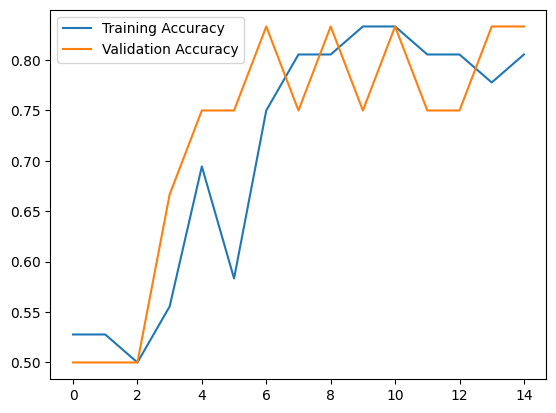

Model training completed!


In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

print("Model training completed!")

# Evaluate 

In [15]:
train_score = model.evaluate(train_generator)
valid_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ",test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.7500 - loss: 0.5017
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.4739
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9167 - loss: 0.5261
Train Loss:  0.5088829398155212
Train Accuracy:  0.75
--------------------
Validation Loss:  0.47392216324806213
Validation Accuracy:  0.8333333134651184
--------------------
Test Loss:  0.5260694622993469
Test Accuracy:  0.9166666865348816


# Show

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


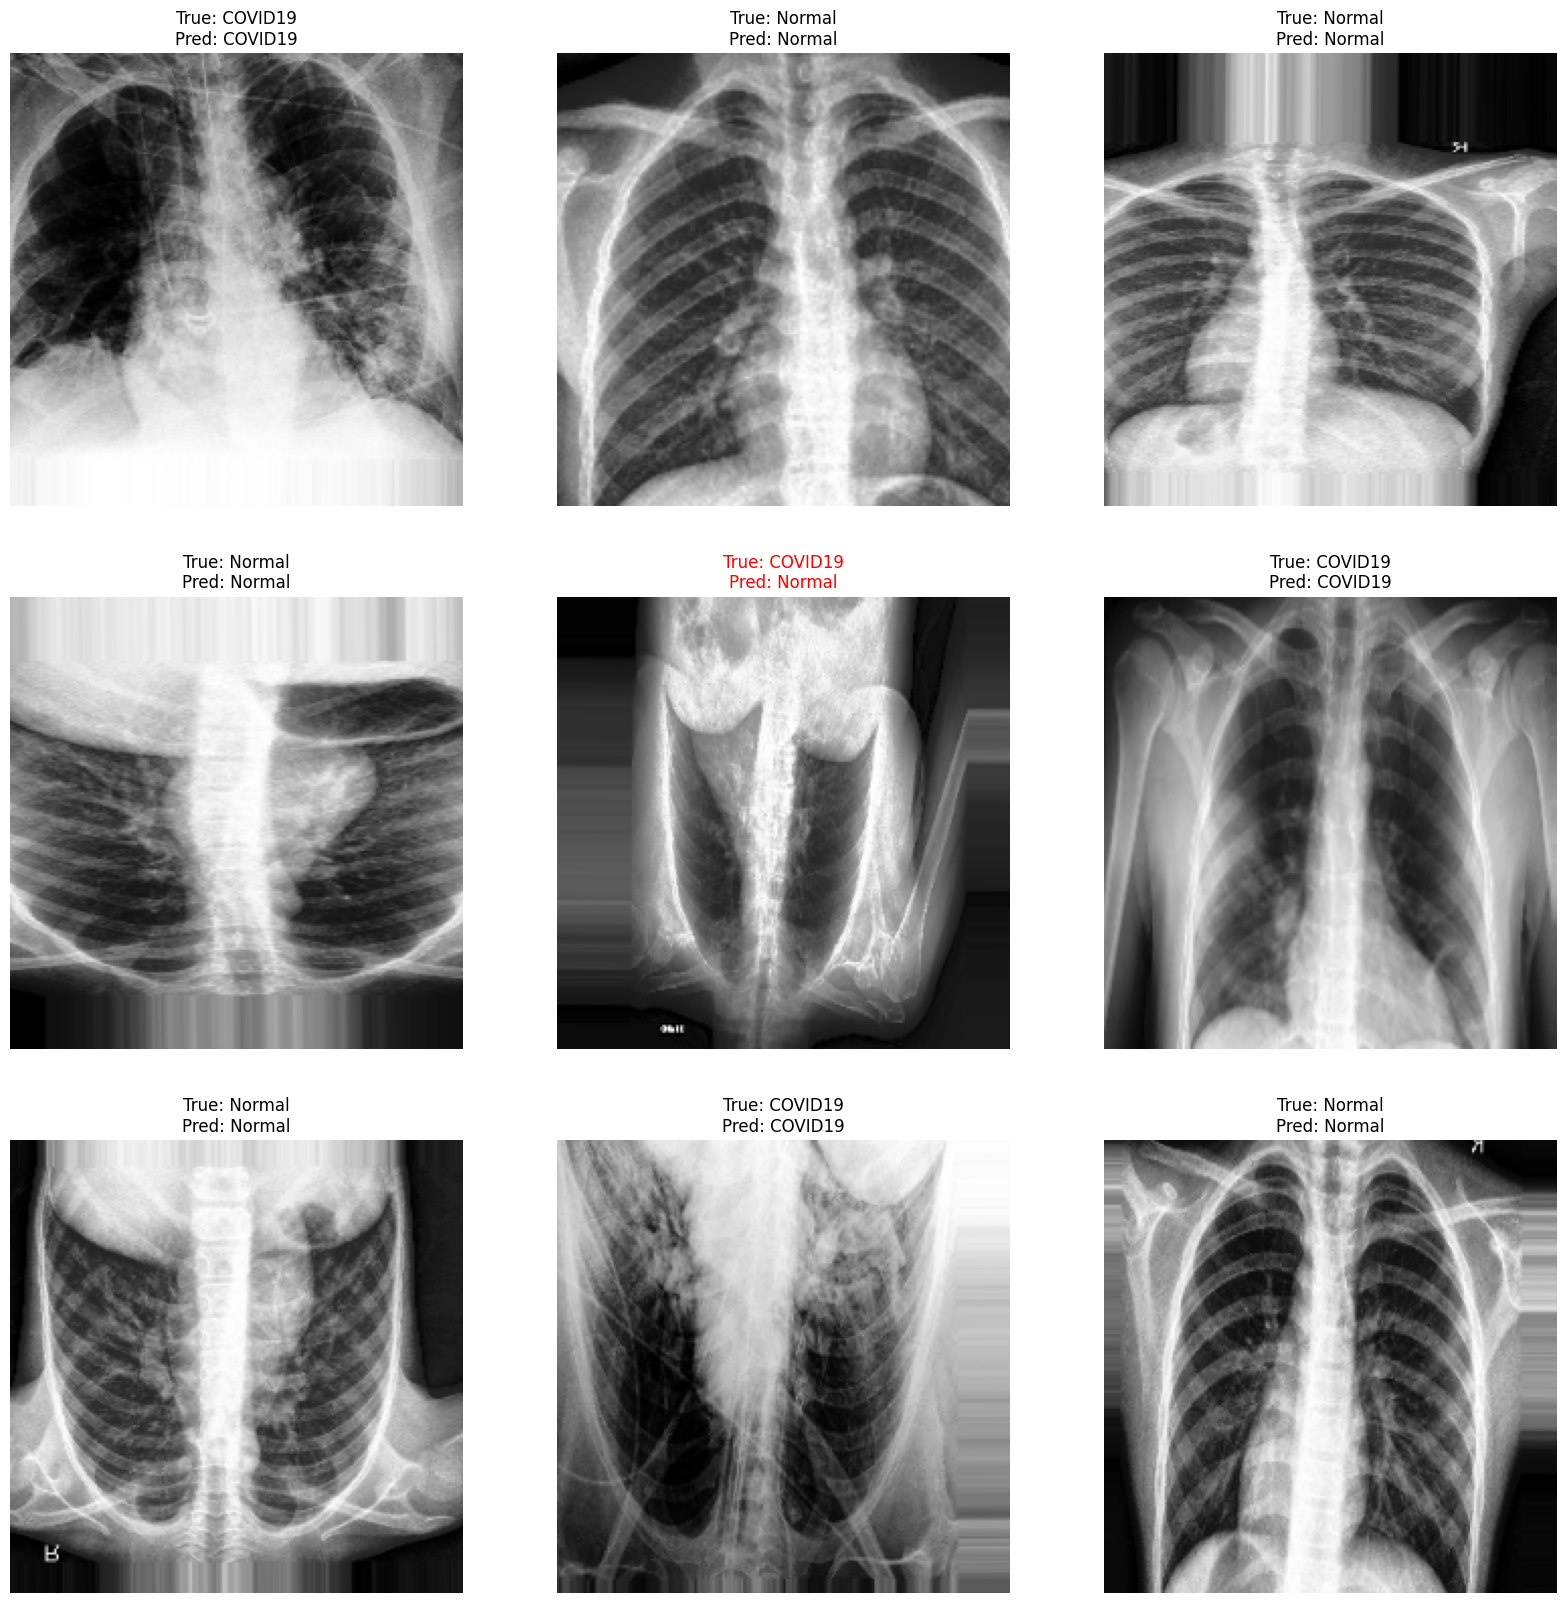

In [16]:
images, labels = test_generator[0]    
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)     
true_classes = np.argmax(labels, axis=1)   
class_labels = list(test_generator.class_indices.keys())  # ['COVID19', 'Normal']
def plot_images(images, true_labels, predicted_labels, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(9):  
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))  
        plt.axis('off')
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}",
                  color="black" if true_label == predicted_label else "red") 
    plt.show()
plot_images(images, true_classes, predicted_classes[:len(images)], class_labels)

# description 

# COVID-19 X-ray Image Classification using InceptionResNetV2
#### This project implements a deep learning pipeline for binary image classification of chest X-ray images to detect COVID-19. It leverages the power of transfer learning using the InceptionResNetV2 architecture pretrained on ImageNet. The pipeline includes data preprocessing, augmentation, training, evaluation, and visualization, designed for high performance and model generalization.

## Dataset
#### The dataset consists of X-ray images divided into two classes:

#### COVID19

#### Normal

#### Data is stored in two directories and loaded using file paths, with balanced stratified splits for train, validation, and test sets:

#### Training set: 60%

#### Validation set: 20%

#### Test set: 20%

## Data Augmentation
#### Implemented using ImageDataGenerator to reduce overfitting and increase robustness:

#### Rescaling

#### Rotation

#### Zoom

#### Shearing

#### Horizontal and vertical flips

#### Width and height shifts

## Model Architecture
#### The model uses InceptionResNetV2 as the base (frozen during training) followed by custom dense layers:

#### text
#### Copy
#### Edit
#### Input: 224x224 RGB X-ray images
#### Base Model: InceptionResNetV2 (include_top=False, pooling='max')
#### Custom Layers:
####   - Flatten
####   - Dense(512) → ReLU
####   - Dense(256) → ReLU
####   - Dense(128) → ReLU
####   - Dense(64) → ReLU
####   - Dense(32) → ReLU
####   - Output: Dense(2) → Softmax
## Training
#### Optimizer: Adamax with learning rate = 1e-4

#### Loss Function: Categorical Crossentropy

#### Metrics: Accuracy

### Callbacks:

#### EarlyStopping (monitoring val_loss)

#### ModelCheckpoint (saving best model)

#### ReduceLROnPlateau (monitoring val_loss)

## Evaluation
#### After training, the model is evaluated on:

#### Training data

#### Validation data

#### Test data

### Final Scores:
#### Train Accuracy: 75%

#### Validation Accuracy: 83.3%

#### Test Accuracy: 91.7%

#### Confusion matrix and classification report are generated. Sample predictions with true vs predicted labels are visualized to understand performance.

## Visualization
#### Accuracy curves for training and validation

#### Image plots with predictions: true label vs predicted label (highlighted in red if incorrect)

## How to Run
#### Clone the repo and navigate to the project directory

#### Update dataset paths in the script

### Install dependencies:

#### bash
#### Copy
#### Edit
#### pip install tensorflow numpy pandas opencv-python matplotlib scikit-learn
#### Run the training script.

## Future Improvements
#### Fine-tuning the base model (unfreeze upper layers)

#### Add dropout layers to reduce overfitting

#### Expand dataset for better generalization

#### Implement Grad-CAM for visual explanations

## License
#### This project is licensed under the MIT License.